# Assignment - NST

## Anindya Sen (224102306), IIT, Guwahati

Neural Style Transfer (NST) leverages a pre-trained convolutional neural network, exemplifying the concept of transfer learning, where a network trained on a very large dataset for one task is repurposed for another. We will define our cost functions and use the pretrained CNN as a pattern extractor.

In this case, we will utilize the renowned VGG network, named after its creators from the Visual Geometry Group at the University of Oxford. The research, detailed in the [original NST paper](https://arxiv.org/abs/1508.06576) published in 2014, introduced the use of VGG-19. This variant, comprising 19 layers, has been extensively trained on the extensive ImageNet database. Through this training, VGG-19 has become adept at identifying various features, recognizing simpler patterns in its earlier layers and more complex ones in its deeper layers.

# **Importing necessary libraries**

In [3]:

import tensorflow as tf
import keras.preprocessing.image as process_im
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import functools
import IPython.display

Using TensorFlow backend.


In [111]:
content_path='/kaggle/input/tamil-nst/TamilContentImages/C_image5.jpg'
style_path = '/kaggle/input/tamil-nst/TamilStyleImages/S_image2.jpg'

In [112]:
content = load_file(content_path)
style = load_file(style_path)

**Define function to load images and return numpy array**

In [113]:
def load_file(image_path):
    image =  Image.open(image_path)
    max_dim=512
    factor=max_dim/max(image.size)
    image=image.resize((round(image.size[0]*factor),round(image.size[1]*factor)),Image.ANTIALIAS)
    im_array = process_im.img_to_array(image)
    im_array = np.expand_dims(im_array,axis=0) #for a batch of images
    return im_array

**Define function to plot image**

In [114]:
def show_im(img,title=None):
    img=np.squeeze(img,axis=0)
    plt.imshow(np.uint8(img))
    plt.axis("off")
    if title is None:
        pass
    else:
        plt.title(title)
    plt.imshow(np.uint8(img))

**Plot Image**

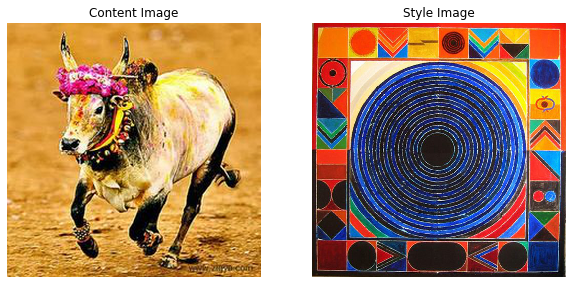

In [115]:
plt.figure(figsize=(10,10))
content = load_file(content_path)
style = load_file(style_path)
plt.subplot(1,2,1)
show_im(content,'Content Image')
plt.subplot(1,2,2)
show_im(style,'Style Image')
plt.show()

**Define function to process image for input to vgg19 model**

In [116]:
def img_preprocess(img_path):
    image=load_file(img_path)
    img=tf.keras.applications.vgg19.preprocess_input(image)
    return img

In [117]:
def rev_process_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3 #Input dimension must be [1, height, width, channel] or [height, width, channel]
  
  #VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68]and with channels BGR.
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1] # converting BGR to RGB channel

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [118]:
im=img_preprocess(content_path)

**Get necessary layers from vgg19 model**

In [119]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
number_content=len(content_layers)
number_style =len(style_layers)

**Define function to get vgg19 model with pretrained weights**

In [120]:
def get_model():
    
    vgg=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
    vgg.trainable=False
    content_output=[vgg.get_layer(layer).output for layer in content_layers]
    style_output=[vgg.get_layer(layer).output for layer in style_layers]
    model_output= style_output+content_output
    return models.Model(vgg.input,model_output)

In [121]:
model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

**Model architecture**

In [122]:
model=get_model()
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0  

# **Loss Functions**

- First, we will construct the content loss function $J_{\text{content}}(C,G)$.
- Second, we will develop the style loss function $J_{\text{style}}(S,G)$.
- Finally, we'll combine these to formulate $J(G) = \alpha J_{\text{content}}(C,G) + \beta J_{\text{style}}(S,G)$.

(G - generated image, C - content image, S - Style image)

**Content Loss**

Content loss is essentially the calculation of the root mean squared error (RMSE) between the activations from both the generated and content images.

In [123]:
def get_content_loss(noise,target):
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss

**Style Loss**

Our aim here is to derive style matrices for both the generated and style images. Style loss is then quantified as the root mean square difference between these matrices. This measure of style hinges on the correlation level among feature maps within a layer. Subsequently, the loss represents the disparity in correlation among feature maps as produced by both the generated and style images. Utilization of the Gram matrix enables the assessment of correlation within feature maps from a convolutional layer.

In [124]:
def gram_matrix(tensor):
    channels=int(tensor.shape[-1])
    vector=tf.reshape(tensor,[-1,channels])
    n=tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

In [126]:
def get_style_loss(noise,target):
    gram_noise=gram_matrix(noise)
    #gram_target=gram_matrix(target)
    loss=tf.reduce_mean(tf.square(target-gram_noise))
    return loss
    

In [128]:
def get_features(model,content_path,style_path):
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)
    
    content_output=model(content_img)
    style_output=model(style_image)
    
    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature
    

**Total loss**

In [130]:
def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    style_weight,content_weight = loss_weights #style weight and content weight are user given parameters
                                               #that define what percentage of content and/or style will be preserved in the generated image
    
    output=model(image)
    content_loss=0
    style_loss=0
    
    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]
    
    weight_per_layer = 1.0/float(number_style)
    for a,b in zip(gram_style_features,noise_style_features):
        style_loss+=weight_per_layer*get_style_loss(b[0],a)
        
    
    weight_per_layer =1.0/ float(number_content)
    for a,b in zip(noise_content_feature,content_features):
        content_loss+=weight_per_layer*get_content_loss(a[0],b)
        
    style_loss *= style_weight
    content_loss *= content_weight
    
    total_loss = content_loss + style_loss
    
    
    return total_loss,style_loss,content_loss

**Calculate gradient for optimization**

In [131]:
def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)
        
    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

In [132]:
def run_style_transfer(content_path, style_path, epochs=500, content_weight=1e3, style_weight=1e-2):
    
    # Initialize the model and set layers to non-trainable
    style_model = get_model()
    for layer in style_model.layers:
        layer.trainable = False

    # Extract content and style features
    features_content, features_style = get_features(style_model, content_path, style_path)
    gram_matrices_style = [gram_matrix(feature) for feature in features_style]

    # Prepare the initial noise image
    initial_noise = img_preprocess(content_path)
    noise_image = tf.Variable(initial_noise, dtype=tf.float32)

    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    optimal_loss = float('inf')
    optimal_image = None

    # Loss weights and parameters dictionary
    weights = (style_weight, content_weight)
    params = {'model': style_model, 'loss_weights': weights, 'image': noise_image, 
              'gram_style_features': gram_matrices_style, 'content_features': features_content}

    # Normalization parameters
    normalization_means = np.array([103.939, 116.779, 123.68])
    lower_bound = -normalization_means
    upper_bound = 255 - normalization_means

    # Initialize lists to store losses
    total_losses = []
    style_losses = []
    content_losses = []

    # List to store images for visualization
    generated_images = []
    for epoch in range(epochs):
        gradients, losses = compute_grads(params)
        total_loss, loss_style, loss_content = losses
        adam_optimizer.apply_gradients([(gradients, noise_image)])
        
        # Clipping the noise image and updating
        clipped_image = tf.clip_by_value(noise_image, lower_bound, upper_bound)
        noise_image.assign(clipped_image)

        total_losses.append(total_loss.numpy())
        style_losses.append(loss_style.numpy())
        content_losses.append(loss_content.numpy())
   
        # Update the best loss and image
        if total_loss < optimal_loss:
            optimal_loss = total_loss
            optimal_image = deprocess_img(noise_image.numpy())

        # Visualization and logging
        if epoch % 5 == 0:
            visualized_image = deprocess_img(noise_image.numpy())
            generated_images.append(visualized_image)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(visualized_image))
            print(f'Epoch: {epoch}')        
            print(f'Total loss: {total_loss:.4e}, Style loss: {loss_style:.4e}, Content loss: {loss_content:.4e}')

    # Clear output and return the results
    IPython.display.clear_output(wait=True)
    return optimal_image, optimal_loss, generated_images, (total_losses, style_losses, content_losses)


# **Visualizations**

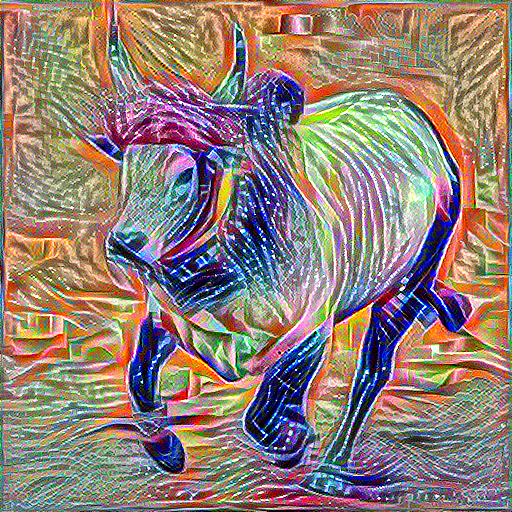

Epoch: 200
Total loss: 1.8134e+07, Style loss: 1.4884e+07, Content loss: 3.2499e+06


In [133]:
epochs = 201
best, best_loss, image, (total_losses, style_losses, content_losses) = \
                      run_style_transfer(content_path, style_path, epochs=epochs)

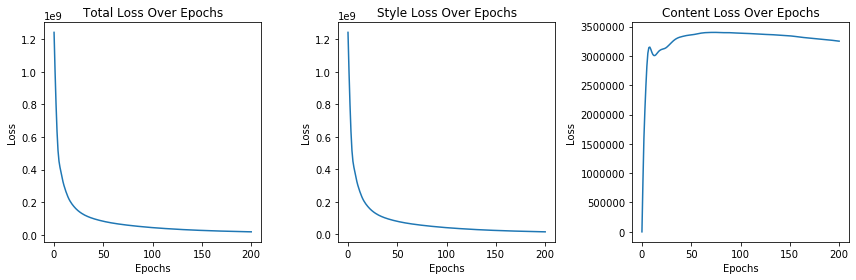

In [134]:
# Plotting the learning curves
epochs_range = range(epochs)
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, total_losses, label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Total Loss Over Epochs')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, style_losses, label='Style Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Style Loss Over Epochs')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, content_losses, label='Content Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Content Loss Over Epochs')

plt.tight_layout()
plt.show()

## Example 1

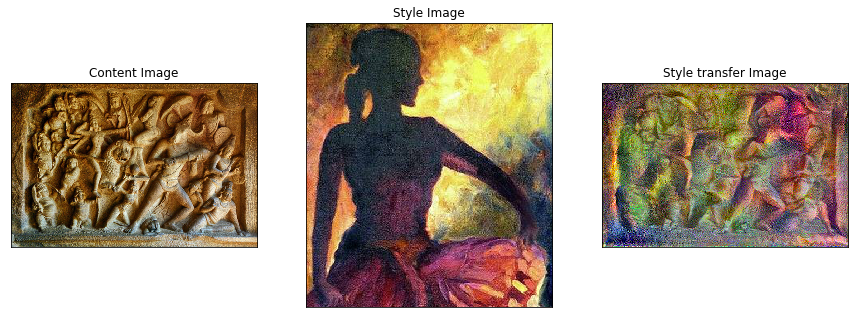

In [49]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,3)
plt.imshow(best)
plt.title('Style transfer Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,1)
show_im(content,'Content Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
show_im(style,'Style Image')
plt.xticks([])
plt.yticks([])
plt.show()

## Example 2

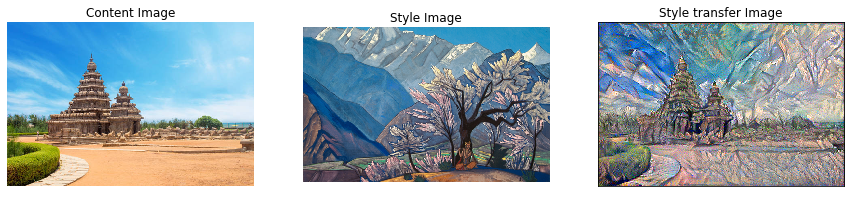

In [96]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,3)
plt.imshow(best)
plt.title('Style transfer Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,1)
show_im(content,'Content Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
show_im(style,'Style Image')
plt.xticks([])
plt.yticks([])
plt.show()